# Preamble
The codeblocks below are there to import the right packages, provide some helper functions, and hardcode a number of often used values. If you find yourself needed to make adjustments to these codeblocks to make the code work, please let us know as this most likely means that something has gone wrong in our implementation.

In [1]:
%matplotlib inline

import torch
import numpy as np

from tqdm import tqdm

import torch.distributions as D

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

from scipy.stats import multivariate_normal

import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import multivariate_normal

import torch
from torch.distributions import Categorical, Normal

In [2]:
def reset_seeds(seed=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  np.random.seed(seed)

In [3]:
def plot(X, means, log_vars, logits, alphas):
    # Convert parameters to NumPy for plotting
    means_np = means.detach().numpy()
    stds_np = torch.exp(0.5 * log_vars).detach().numpy()
    weights_np = torch.softmax(logits, dim=0).detach().numpy()

    # Calculate the most probable component for each data point from Q(z)
    assignments = torch.argmax(torch.softmax(alphas, dim=1), dim=1).detach().numpy()
    # print
    # print(assignments)

    # Create a grid for plotting
    x = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, num=100)
    y = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, num=100)
    X_grid, Y_grid = np.meshgrid(x, y)
    pos = np.dstack((X_grid, Y_grid))

    # Calculate the GMM density over the grid
    Z_grid = np.zeros(X_grid.shape)
    for weight, mean, std in zip(weights_np, means_np, stds_np):
        rv = multivariate_normal(mean, np.diag(std**2))
        Z_grid += weight * rv.pdf(pos)

    # Plot the density contours
    plt.figure(figsize=(10, 8))
    contour = plt.contourf(X_grid, Y_grid, Z_grid, levels=40, cmap='viridis', alpha=0.8)
    plt.colorbar(contour)

    # Define a colormap for the data points and means
    cmap = plt.cm.get_cmap('viridis', len(weights_np))

    # Overlay the data samples colored by their most likely GMM component
    scatter = plt.scatter(X[:, 0], X[:, 1], c=assignments, cmap=cmap, s=50, edgecolor='k', alpha=0.9)

    # Mark the means of the GMM components with corresponding colors
    for i, mean in enumerate(means_np):
        plt.scatter(mean[0], mean[1], c=[cmap(i)], s=200, edgecolor='k', marker='X')

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

# Administrative Information
Again, please note that none of the tasks set are supposed to be extremely challenging and if you do run into any problems, chances are high that this is due to unclarity on our side. As such, if you are stuck on a task for a longer time, do please reach out to lars@aims.ac.za

This week we will be organizing the coding task slightly different:
- The assignment is only introduced at the end of the notebook. This assignment will ask you to perform some small experiment to see how different hyperparameters or modelling decisions change the final outcome.
- The assignment will primarily ask you to implement some logging + visualization and to interpret the results.
- Additional optional experiments will be proposed, but it is not neccesary to complete these.
- Discuss your experimental results in the markdown block containing the keyword "*Answer:*".


Lastly, to help us in improving the coding assignments, please fill in the anonymous feedback [form](https://forms.gle/vVBXm7nhW94yMkHr8) (you can do this for every assigment, just make sure to pick the correct day you just finished in the sheet). We highly appreciate your feedback, positive and negative!

# Variational Expectation-Maximization
In this notebook we will be implementing the Variational Expectation-Maximization (VEM) as discussed in the second chapter of the lecture notes.

VEM is a Latent Variable model trained using maximal marginal log-likelihood maximization. It does this using two steps; the VE-Step and the VM-step. In the VE-step we optimize the parameters of the inference distribution $Q_n$ (on model for each sample $n$, and consecutively, we update the parameters of the Graphical Model $P$ during the VM-step.

We will be implementing both of these steps below, but first we will take a look at the dataset we will be working with.

## Dataset
As said, VEM is a training method for maximizing the Marginal Log-Likelihood of a Graphical Model $P$ for a given dataset. Ie. we want $P$ to, after training, assign high probability to samples from the dataset.

As such, we will first need to obtain a dataset. While we will have access to the true data generating distribution for this step, one needs to assume that we somehow lose access to this distribution after we have generated the dataset.

Specifically, we will be using a Gaussian Mixture Model for generating the data. This is implemented below.

In [22]:
reset_seeds()

# Parameters for the GMM components
n_data = 500  # Total number of data points
n_gaussians = 10  # Number of GMM mixture components

# Generate parameters for GMM components
means = torch.rand(n_gaussians, 2) * 10 - 5  # Uniformly distributed in [-5, 5]
stds = torch.rand(n_gaussians, 2) * 1 + 0.5  # Uniformly distributed in [0.5, 1.5]

mixture_weights = torch.ones(n_gaussians) / n_gaussians  # Equal weights for simplicity
mixture_distribution = torch.distributions.Categorical(mixture_weights)
component_distribution = torch.distributions.Independent(torch.distributions.Normal(means, stds), 1)
gmm = torch.distributions.MixtureSameFamily(mixture_distribution, component_distribution)

# Sample data from the GMM
X = gmm.sample((n_data,))

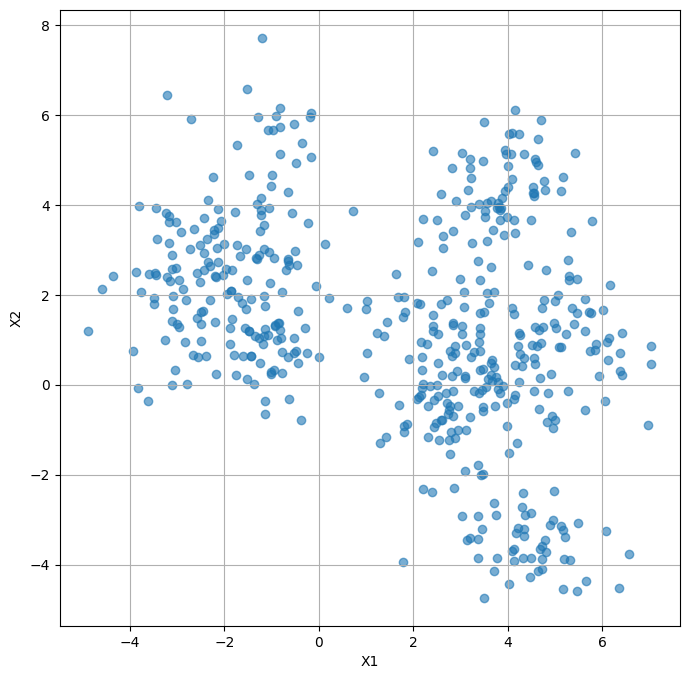

In [23]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], alpha=0.6)

# plt.title(f'Synthetic Data from a Random {n_components}-Component GMM')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()

## Model definition
The next step is to define the inference model $Q_n$, the GM $P(x|z)$ and the prior $P(z)$. The functional form of these models is an important modelling decision.

We will be implementing the GM $P(x|z)$ using a Gaussian Mixture Model, with the prior $P(z)$ being a single Categorical distribution. Similarly, we will be using a Categorical distribution to implement the variational inference distribution $Q_n$. Note that we have one inference distribution for each datasample $x_n$.

We have implemented these distributions below. It is important to observe that we have implemented these distributions using learnable parameters. We will be updating these parameters during the VE and VM steps.


In [9]:
def init_q_n(n_samples, n_components):# Collection of Categorical distributions. We have one for each datasample.
    alphas = torch.randn(n_samples, n_components, requires_grad=True) # See that Q is defined for every data point
    return alphas

def sample_q_n(alphas, size=(1,)):
    return Categorical(logits=alphas).sample(size)

def log_prob_q_n(alphas, x):
    q_n = Categorical(logits=alphas)
    return q_n.log_prob(x)

def init_p_z(n_components): # Prior P(z)
    logits = torch.zeros(n_components, requires_grad=True)
    return logits

def sample_p_z(logits, size=(1,)):
    return Categorical(logits=logits).sample(size)

def log_prob_p_z(logits, z):
    p_z = Categorical(logits=logits)
    return p_z.log_prob(z)

def init_p_x_given_z(n_components, n_features): # GMM P(x|z)
    means = torch.randn(n_components, n_features, requires_grad=True)
    log_vars = torch.zeros(n_components, n_features, requires_grad=True)
    return means, log_vars

def sample_p_x_given_z_given_z(means, log_vars, z):
    expanded_means = means[z]
    expanded_stds = (log_vars.exp().sqrt())[z]

    dist = Normal(expanded_means, expanded_stds)
    samples = dist.sample()

    return samples

def log_prob_p_x_given_z(means, log_vars, x, z):
    p_x_given_z = [Normal(mean, log_var.exp().sqrt()) for mean, log_var in zip(means.unbind(0), log_vars.unbind(0))]
    log_probs = torch.stack([dist.log_prob(x) for dist in p_x_given_z])
    selected_log_probs = log_probs[z]

    return selected_log_probs.sum(-1)

## E-Step
The first part of the EM-algorithm that we will be implementing is the e-step. If you look below, you will find a commented out block of code. This code describes the update steps as described in eq. 2.9-2.11. This code works and you are free to test it, however, as we are using a Categorical distribution for Q we can simply get the probabilities for each component instead of performing a MC integration. This is implemented in the next block.

In [ ]:
# def e_step(X, alphas, logits, means, log_vars, optimizer_e, n_samples=100):
#     optimizer_e.zero_grad()

#     total_objective = 0.0

#     for _ in range(n_samples):
#         # Sample z from q_n for each data point in X
#         z = sample_q_n(alphas, size=(1,))

#         # Calculate the log probability of the variational distribution Q(z)
#         log_q_n = log_prob_q_n(alphas, z)

#         # Calculate the log probability of P(x|z)
#         log_p_x_given_z = log_prob_p_x_given_z(means, log_vars, X, z)

#         # Calculate the log probability of P(z)
#         log_p_z = log_prob_p_z(logits, z)

#         # Calculate the variational lower bound (the objective to be maximized)
#         objective = (log_p_x_given_z + log_p_z - log_q_n).mean()
#         total_objective += objective

#     # Average the objective across all samples
#     avg_objective = total_objective / n_samples

#     # Minimize the negative of the average objective to maximize the variational lower bound
#     (-avg_objective).backward()

#     # Update alphas using the optimizer
#     optimizer_e.step()

#     return avg_objective


In [10]:
def e_step(X, alphas, logits, means, log_vars, optimizer_e):
    optimizer_e.zero_grad()

    # Compute the probabilities from alphas
    q_n = torch.softmax(alphas, dim=1)  # Softmax to get probabilities from logits

    # Compute log probabilities for all z under the variational distribution
    log_q_n = torch.log(q_n + 1e-8)  # Add a small number to prevent log(0)

    # Compute log probabilities for all z under the prior P(z)
    log_p_z = torch.log_softmax(logits, dim=0)  # Use log softmax for numerical stability

    # Compute expected log probabilities of P(x|z) over all components
    log_p_x_given_z_all = torch.stack([log_prob_p_x_given_z(means, log_vars, X, z)
                                       for z in range(n_components)], dim=1)

    # Compute the objective function as the expectation of the log likelihood over all components
    objective = (q_n * (log_p_x_given_z_all + log_p_z - log_q_n)).sum(dim=1).mean()

    # Minimize the negative of the objective to maximize the variational lower bound
    (-objective).backward()

    # Update alphas using the optimizer
    optimizer_e.step()

    return objective


## M-Step
For the M-Step we will use the same trick as for the e-step by directly taking the probabilities of the categorical distribution $P(z)$ instead of sampling.

In [11]:
def m_step(X, alphas, means, log_vars, logits, optimizer_m):
    optimizer_m.zero_grad()

    # Compute the soft assignments q_n
    q_n = torch.softmax(alphas, dim=1)

    # Compute the log probabilities for all components
    log_p_x_given_z_all = torch.stack([log_prob_p_x_given_z(means, log_vars, X, z)
                                       for z in range(n_components)], dim=1)


    # Compute the expected complete log likelihood for all components
    expected_log_likelihood = (q_n * log_p_x_given_z_all).sum(dim=0).sum()

    # Backpropagate the expected log likelihood
    (-expected_log_likelihood).backward()

    # Perform a gradient ascent step to update the parameters
    optimizer_m.step()

    # Clear the gradients for the next step
    optimizer_m.zero_grad()

    return expected_log_likelihood


## Combining it all
Now that we have the VE and VM steps implemented we can run the algorithm.

In [24]:
# Example usage:
n_components = 5 # Number of components in the GMM

# Initialize the distributions
alphas = init_q_n(n_data, n_components)
logits = init_p_z(n_components)
means, log_vars = init_p_x_given_z(n_components, 2)

In the figure below we visualize the learned probability distribution at initialization (with the parameters randomized). The "X"s represent the means of the Gaussians in the GMM. The data samples are colored according to their hard assignment to one of the clusters as learned by Q.

<ipython-input-3-5ffeffe6ee9b>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(weights_np))


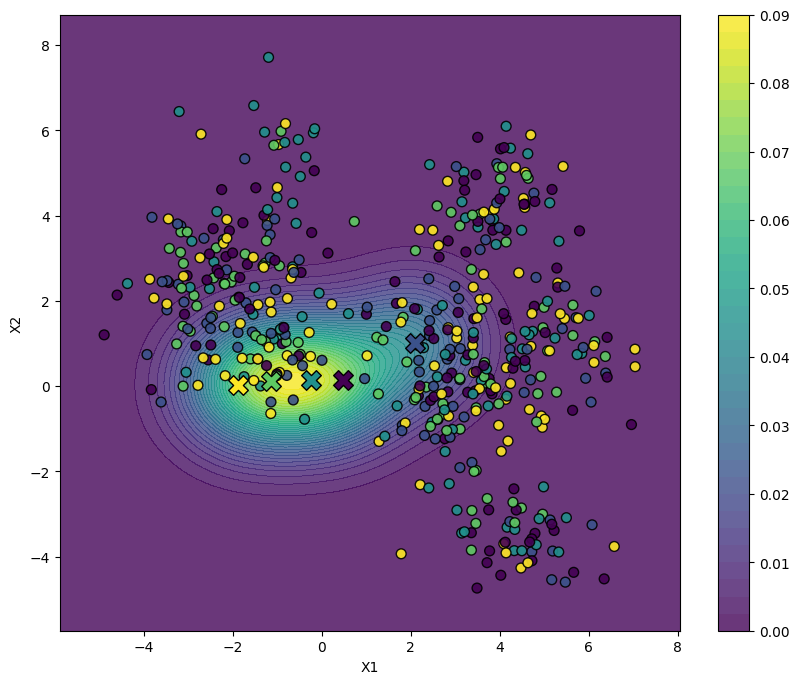

In [25]:
plot(X, means, log_vars, logits, alphas)

In [26]:
# Define the optimizers
optimizer_e = torch.optim.Adam([alphas], lr=0.01)
optimizer_m = torch.optim.Adam([means, log_vars, logits], lr=0.01)

To see the difference between the e-step and the m-step, we will first look at them in isolation. We will run both steps a couple of times to make sure that they have converged. When we combine them into a single training loop, we can choose to also run the two steps to convergence within a single epoch, or just do it for one step each.

After taking 500 e-steps we can see that the model has updated the learned assignments in the inference distribution $Q$.

<ipython-input-3-5ffeffe6ee9b>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(weights_np))


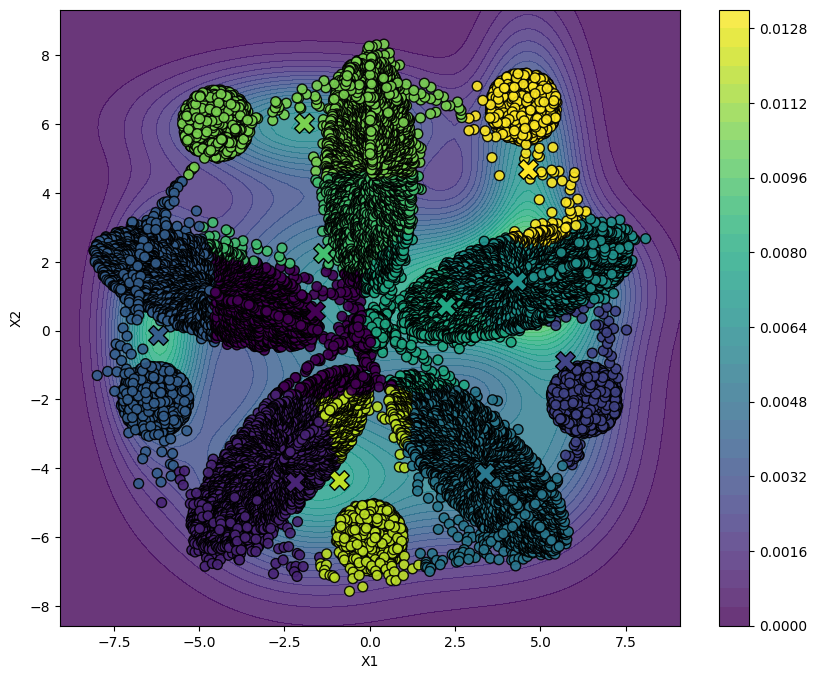

In [ ]:
for i in range(500):
  obj = e_step(X, alphas, logits, means, log_vars, optimizer_e)
plot(X, means, log_vars, logits, alphas)

Next we run the m-step 500 times. Here we see how the distribution switches to capture the full data distribution.

<ipython-input-3-5ffeffe6ee9b>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(weights_np))


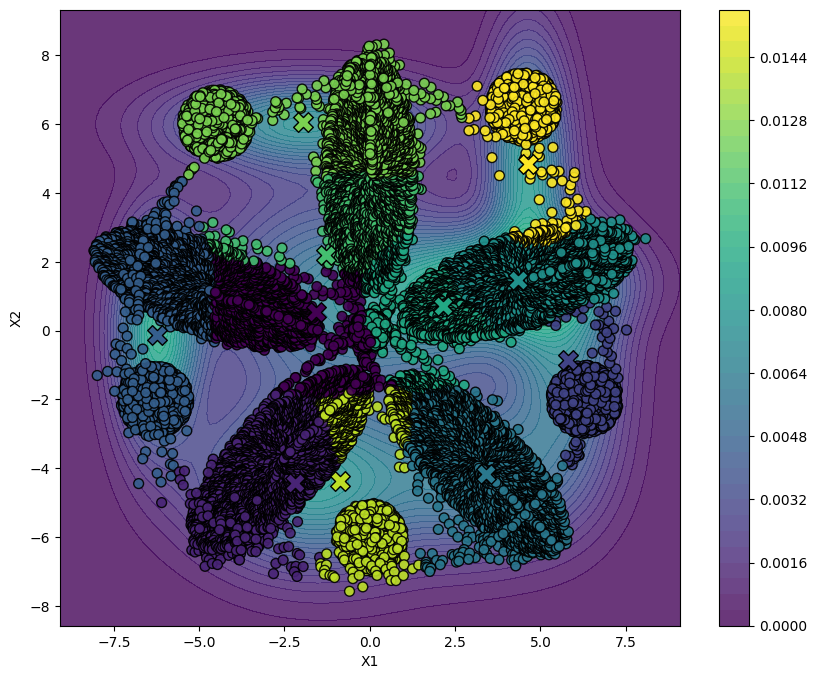

In [ ]:
for i in range(500):
  m_step(X, alphas, means, log_vars, logits, optimizer_m)
plot(X, means, log_vars, logits, alphas)

Now, we combine everything together and see how the e-step and m-step work together to minimize the ELBO.

100%|██████████| 1000/1000 [09:20<00:00,  1.78it/s]
<ipython-input-3-5ffeffe6ee9b>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(weights_np))


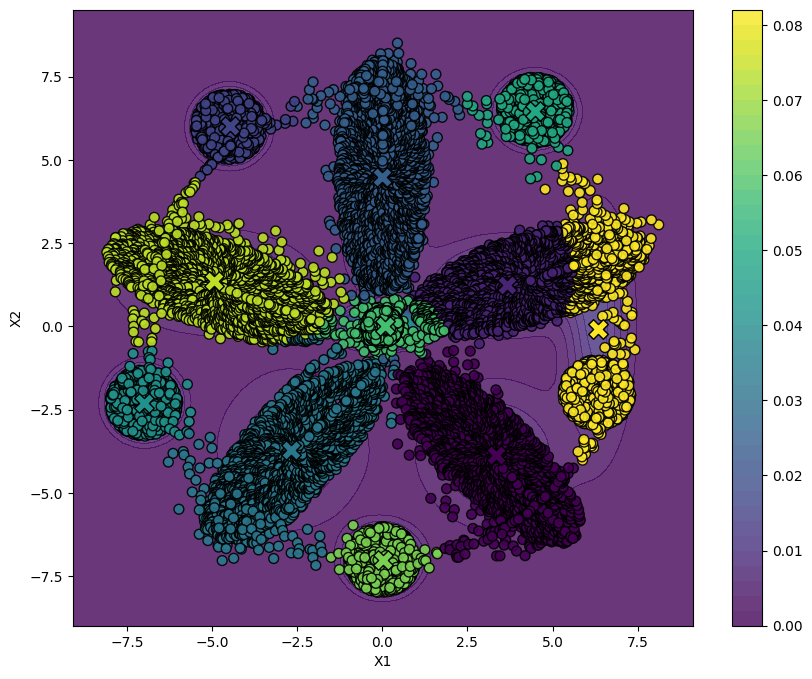

In [19]:

n_iterations = 1000

# Variational EM update loop
for iteration in tqdm(range(n_iterations)):
    e_step(X, alphas, logits, means, log_vars, optimizer_e)
    m_step(X, alphas, means, log_vars, logits, optimizer_m)

plot(X, means, log_vars, logits, alphas)

In [17]:
means

tensor([[ 3.5766, -4.1628],
        [ 4.2073,  1.4487],
        [-4.4772,  6.0101],
        [ 0.0133,  4.4163],
        [-2.9068, -3.8240],
        [-6.8582, -0.7937],
        [ 4.4822,  6.4354],
        [ 0.5503,  0.0278],
        [-0.0090, -6.4072],
        [-3.5845,  0.2509],
        [ 6.3569, -0.3650]], requires_grad=True)

In [18]:
log_vars.exp().sqrt()

tensor([[1.2248, 1.2875],
        [1.2985, 0.7862],
        [0.6037, 0.5242],
        [0.7117, 2.2801],
        [1.7568, 1.9775],
        [0.7350, 2.1029],
        [0.5596, 0.7311],
        [1.1928, 0.9394],
        [0.9130, 1.7394],
        [1.9990, 2.1033],
        [0.5877, 2.1133]], grad_fn=<SqrtBackward0>)

## Assignment

During the lecture we discussed a couple of times how we can choose different schedules for the interplay between the e-step and the m-step.

For example, as I already hinted at before, we can either run the EM-steps to convergence at every time, or we can just take a single step for both the E and M step. Alternatively, we can choose to run one of them to run till convergence while we only do one step of the other. Or, instead of running the E-step on all datasamples, we could choose to only do it on a randomly selected subset.

In any case, it is clear that there are many options for this schedule.

In this assignment we are going to explore how this decision changes the final performance of the algorithm, as measured by the ELBO. We want you to atleast try to implement the alternative schedule where we run the e-steps and m-steps for 100 times in isolation before switching between them.

In pseudocode we can write this as:

```
for 1..N:
  for 1..100:
    run e-step
  for 1..100:
    run m-step
  measure elbo
```

**TASK:**
- Use the function below to keep track of the ELBO during training. Ie. add functionality to the training loop above to store the ELBO at every step.
- Use the implemented logging functionality to visualize how the ELBO changes over time.
- Update the training loop to align with the pseudo code below and see if this changes the final result.
- Discuss your observations in the markdown block below.
- (Optional) Try different schedulers to see what works best

In [ ]:
def calculate_elbo(X):
    # Initialization
    n_samples = X.size(0)

    # Sample from q(z|x)
    z_samples = sample_q_n(alphas)

    # Log probability under the model p(x|z)
    log_prob_x_given_z = log_prob_p_x_given_z(means, log_vars, X, z_samples)

    # KL divergence between q(z|x) and p(z)
    log_prob_q = log_prob_q_n(alphas, z_samples)
    log_prob_p = log_prob_p_z(logits, z_samples)
    kl_divergence = (log_prob_q - log_prob_p).sum()

    # Calculate ELBO
    elbo = log_prob_x_given_z.mean() - kl_divergence

    return elbo

In [ ]:

def intitialization():
  # Example usage:
  n_components = 5  # Number of components in the GMM
  # Initialize the distributions
  alphas = init_q_n(n_data, n_components)
  logits = init_p_z(n_components)
  means, log_vars = init_p_x_given_z(n_components, 2)
  ## optimizer
  optimizer_e = torch.optim.Adam([alphas], lr=0.01)
  optimizer_m = torch.optim.Adam([means, log_vars, logits], lr=0.01)
  ## elbo container



<ipython-input-30-5ffeffe6ee9b>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(weights_np))


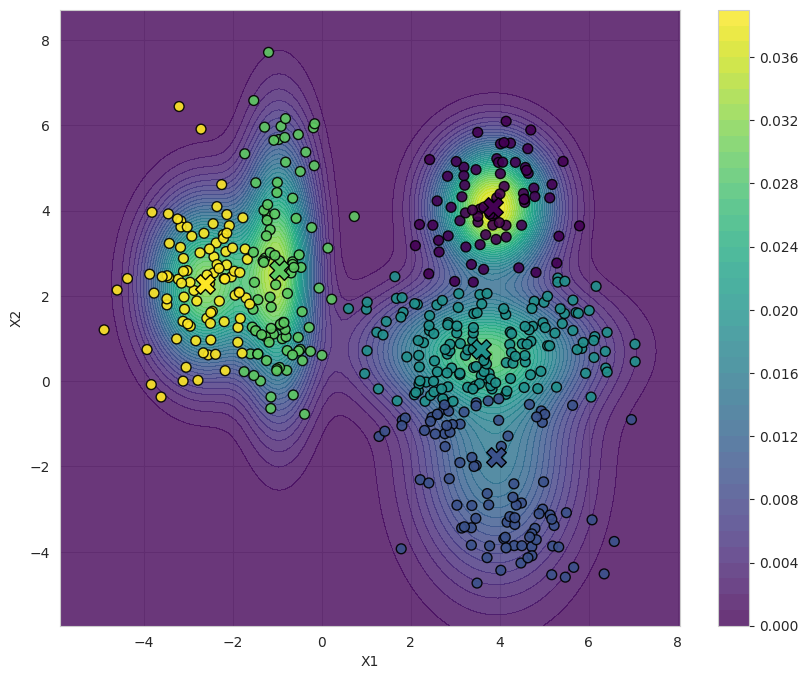


elbo_experiment_1: tensor([-665.3900, -683.9368, -643.0811, -648.6757, -676.3705, -647.9802,
        -642.3587, -661.1621, -651.1027, -662.9818, -647.6797, -666.2243,
        -652.6337, -649.8565, -667.6978, -631.5972, -652.8240, -659.2551,
        -653.3617, -661.6378])


In [ ]:
#@title Schedule from the Task : Schedule_1
elbo1=[]
# initialize
intitialization()
# loop
for _ in range(20):
  for  i in range(100):
    e_step(X, alphas, logits, means, log_vars, optimizer_e)
  for j in range(100):
    m_step(X, alphas, means, log_vars, logits, optimizer_m)
  elbo1.append(calculate_elbo(X))

# visualize
plot(X, means, log_vars, logits, alphas)

# ELBO values
elbo_1=torch.tensor(elbo1)
print('')
print('elbo_experiment_1:', elbo_1)

## Scheddule_2:

description:

Run the EM-steps to convergence at every time (2000 iterations). Record the ELBO
after 100 iterations troughout the proceesss ( 20 ELBO values).

<ipython-input-30-5ffeffe6ee9b>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(weights_np))


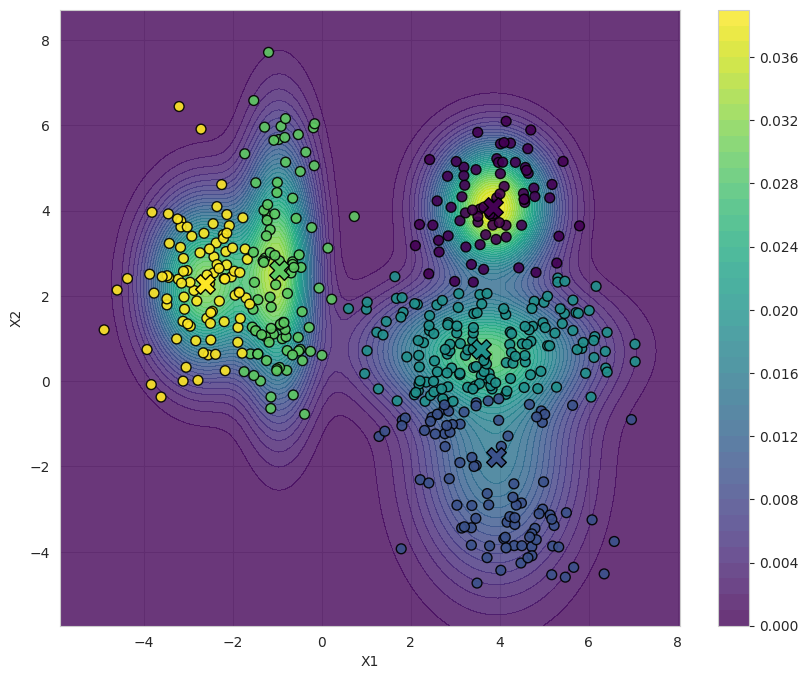


elbo_experiment_2: tensor([-660.1597, -658.9774, -648.2935, -663.5063, -656.8760, -671.6515,
        -679.5473, -663.7513, -655.5286, -658.5519, -685.0795, -674.1161,
        -655.4537, -646.5257, -661.8463, -661.7704, -665.7185, -674.3985,
        -680.3691, -677.0448])


In [ ]:

elbo2=[]
# initialize
intitialization()
# loop
for _ in range(20):
  for  i in range(100):
    e_step(X, alphas, logits, means, log_vars, optimizer_e)
    m_step(X, alphas, means, log_vars, logits, optimizer_m)
  elbo2.append(calculate_elbo(X))

# visualize
plot(X, means, log_vars, logits, alphas)

# ELBO values
elbo_2=torch.tensor(elbo2)
print('')
print('elbo_experiment_2:', elbo_2)


## Scheddule_3:

description:

Run the E-steps till convergence while doing one step  for the M-step.


<ipython-input-30-5ffeffe6ee9b>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(weights_np))


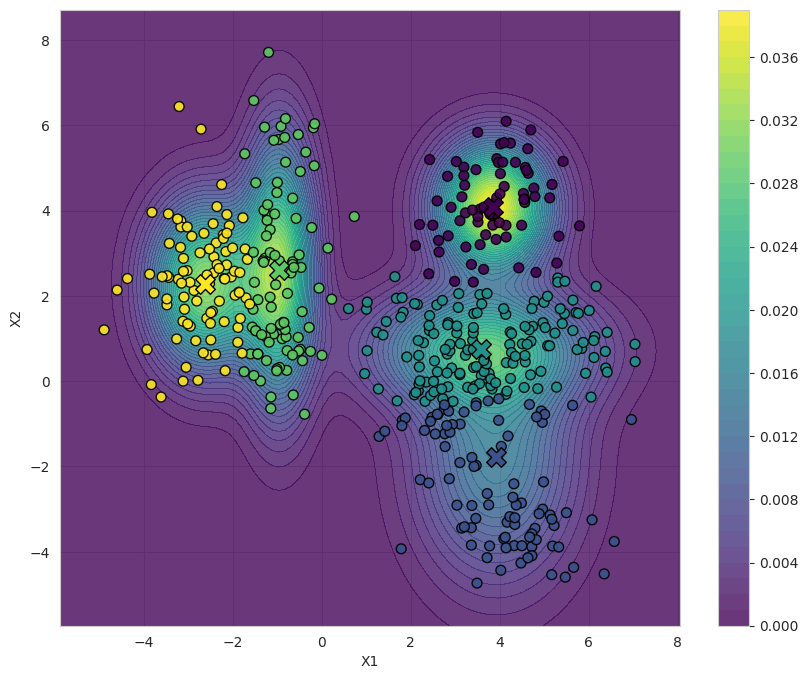


elbo_experiment_3: tensor([-662.9052, -664.0668, -654.3864, -641.0461, -667.0987, -655.7585,
        -637.1935, -660.8650, -657.5900, -664.8653, -668.0098, -659.5312,
        -670.0820, -631.6857, -666.8139, -669.1835, -638.8199, -658.3851,
        -629.4329, -676.5601])


In [ ]:

elbo3=[]
# initialize
intitialization()
# loop
for _ in range(20):
  for  i in range(100):
    e_step(X, alphas, logits, means, log_vars, optimizer_e)
  for j in range(1):
    m_step(X, alphas, means, log_vars, logits, optimizer_m)
  elbo3.append(calculate_elbo(X))

# visualize
plot(X, means, log_vars, logits, alphas)

# ELBO values
elbo_3=torch.tensor(elbo3)
print('')
print('elbo_experiment_3:', elbo_3)

## Schedule_4:

reverse process of shedule_3. Run the M-step till convergence while taking one doing one E-step.

<ipython-input-30-5ffeffe6ee9b>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(weights_np))


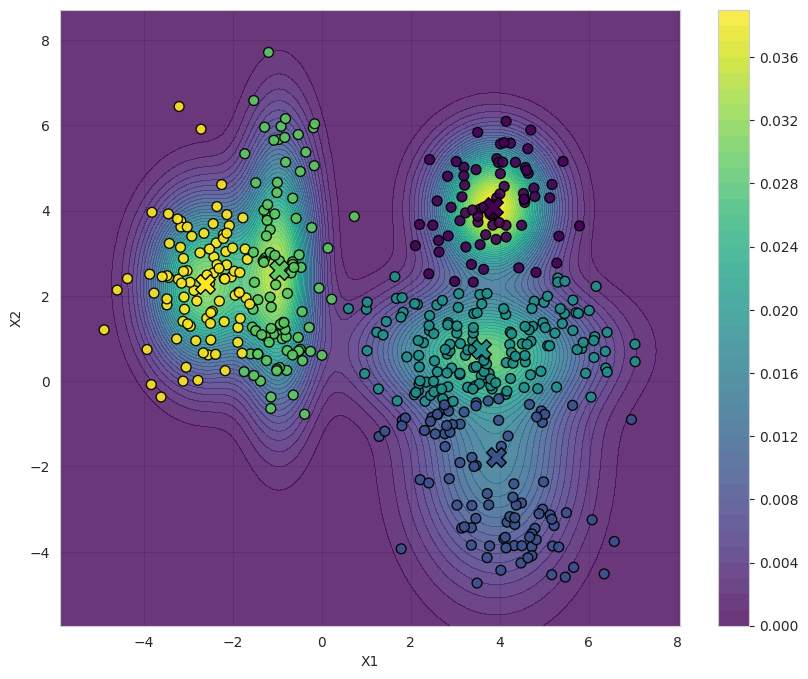


elbo_experiment_4: tensor([-666.6177, -660.9128, -651.9489, -670.1388, -655.8139, -678.9260,
        -652.0481, -662.8639, -663.4378, -685.2245, -680.6973, -638.6412,
        -657.2124, -668.7040, -658.9780, -675.7700, -660.6382, -670.9016,
        -654.7182, -650.9727])


In [ ]:

elbo4=[]
# initialize
intitialization()
# loop
for _ in range(20):
  for  i in range(1):
    e_step(X, alphas, logits, means, log_vars, optimizer_e)
  for j in range(100):
    m_step(X, alphas, means, log_vars, logits, optimizer_m)
  elbo4.append(calculate_elbo(X))

# visualize
plot(X, means, log_vars, logits, alphas)

# ELBO values
elbo_4=torch.tensor(elbo4)
print('')
print('elbo_experiment_4:', elbo_4)

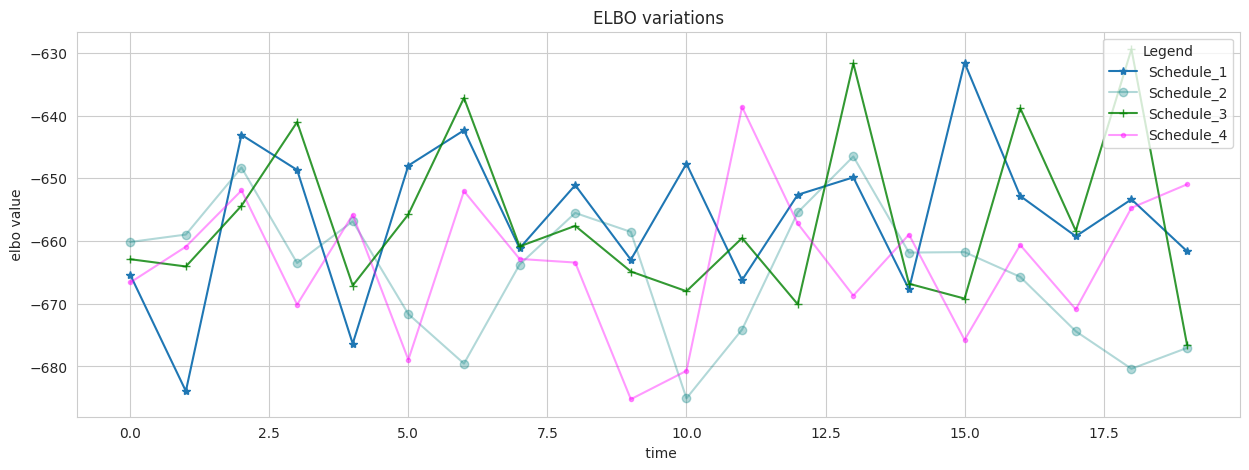

In [ ]:
# time
t=np.arange(20)
# plot
import seaborn as sns

plt.figure( figsize=(15,5))
sns.set_style("whitegrid")
plt.plot(t, elbo_1, marker='*', label='Schedule_1')
plt.plot(t, elbo_2, marker='o', label='Schedule_2',alpha=0.3,color='teal')
plt.plot(t, elbo_3, marker='+', label='Schedule_3',alpha=0.8,color='green')
plt.plot(t, elbo_4, marker='.', label='Schedule_4',alpha=0.4,color='magenta')

plt.title('ELBO variations')
plt.xlabel(' time')
plt.ylabel(' elbo value ')
plt.legend(title='Legend', loc='upper right')
# Show plot
plt.show()

*ANSWER:*
### Discussion:

We noticed after our small experiment that :


* The visual result density is roughly the same for the 4 schedules we used.

* There is fluctuation of the ELBO recorded from each schedule (The ELBO for the 4 schedules is different at each recording time).

* However, the variations of the ELBO of the schedules are not significant and are centered around -660.

* Schedule_1 (the one on the task) is likely to converge very fast compared to the others.

* The performance of each schedule experiment here is acceptable.
